In [1]:
import cv2
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate

# Info

This notebook is primarily for processing gathered data from Google Earth Pro. It splits images into subimages and augments each of them. Also using SIFT detector it extracts all reasonable keypoints and generates mask.

All data for dataset is being stored in .csv file. 

# Adjusting dataset

## Utilities

In [2]:
def list_folders(root: str) -> list:
    names = glob.glob('*', root_dir=root)
    return [name for name in names if os.path.isdir(os.path.join(root, name))]


def build_dataset_file(root: str, output_name: str):
    folder_paths = [os.path.join(root, name) for name in list_folders(root=root)]

    data = []
    for folder_path in folder_paths:
        image_paths = [os.path.join(folder_path, name) for name in glob.glob('*.jpg', root_dir=folder_path)]
        for image_path in image_paths:
            temp_dict = {
                'image_path': image_path,
                'location': image_path.split('/')[-2]
            }
            data.append(temp_dict)

    result = pd.DataFrame(data)
    result.to_csv(output_name, index=False)


def adjust_image(image, adjustment_list: list=None):
    for adjustment in adjustment_list:
        image = adjustment(image)
    return image


def adjust_dataset(dataset: pd.DataFrame, out_dir: str='adjusted', adjustements: list=None):
    os.mkdir(out_dir)

    locations = dataset['location'].unique()
    for location in locations:
        folder_path = os.path.join(out_dir, location)
        os.mkdir(folder_path)

        for _, row in dataset[dataset['location'] == location].iterrows():
            image_path = row['image_path']
            image_name = image_path.split('/')[-1]
            adjusted_image = adjust_image(image=cv2.imread(image_path), adjustment_list=adjustements)
            cv2.imwrite(os.path.join(folder_path, image_name), adjusted_image)

    build_dataset_file(root=out_dir, output_name='adjusted.csv')

# Slicing images

In [3]:
def custom_round(input, threshold: float=0.5):
    '''
        Function rounds to the 1 only if requirement threshold is met.
    '''
    mask = (input > threshold).astype(np.int32)
    inter = np.clip(np.multiply(mask, input), 0, 1)
    return np.ceil(inter)


def slice_image(image, child_num: int=16):
    '''
        This function slices image into child_num parts. Also it is assumed, that shape of the image is also a square.
        Number of childs must be a square!
    '''

    rows = int(np.sqrt(child_num))
    step = image.shape[0] // rows
    childs = []

    for row in range(rows):
        for column in range(rows):
            child_image = image[row * step : (row + 1) * step, column * step : (column + 1) * step].copy()
            childs.append(child_image)

    return childs


def random_rotate(image, mask):
    '''
        One of the homogenius transformations. Rotates mask and image by the random angle.
    '''
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    angle = int(np.random.rand() * 360)

    mean_color = np.mean(image_rgb, axis=(0, 1))

    image_pil = Image.fromarray(image_rgb).rotate(
        angle=angle,
        fillcolor=tuple(np.ceil(mean_color).astype(np.int32))
    )
    mask_rotated = custom_round(np.abs(rotate(mask, angle=angle, order=0, reshape=False)), threshold=0.3)

    image = np.asarray(image_pil)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image_bgr, mask_rotated


def augment_image(image, mask, augmentations: list):
    for augmentation in augmentations:
        image, mask = augmentation(image, mask)

    return image, mask


def get_mask(image, keypoint_detector):
    '''
        Generates mask from the keypoints detected.
    '''
    keypoints = keypoint_detector.detect(image)
    height, width, _ = image.shape
    mask = np.zeros((width, height))

    for keypoint in keypoints:
        x, y = keypoint.pt

        mask[int(y)][int(x)] = 1

    return mask


def process_dataset(dataset: pd.DataFrame, 
                    out_dir: str,
                    augmentations: list=None, 
                    augmentations_per_image: int=1):
    '''
        Generates processed dataset and the DataFrame that contains path to the mask, parent, location.
        
        This function resizes satellite image to 8160x8160 and slices it to the 480x480 childs,
        roughly generating 289 images. With the fact that it also agments images we have
        289 * 2 images, or 289 pairs for training along with their corresponding heatmaps.
    '''
    os.mkdir(out_dir)
    sift = cv2.SIFT_create()

    data = []
    locations = dataset['location'].unique()
    for location in locations:
        folder_path = os.path.join(out_dir, location)
        os.mkdir(folder_path)
        for _, row in dataset[dataset['location'] == location].iterrows():
            image_path = row['image_path']
            image_name = image_path.split('/')[-1]

            image_folder_path = os.path.join(folder_path, image_name.split('.')[0])
            os.mkdir(image_folder_path)
            image = cv2.imread(image_path)
            adjusted_image = adjust_image(image, adjustment_list=[lambda x: cv2.resize(x, dsize=(8160, 8160)),
                                                                  lambda x: cv2.GaussianBlur(x, (5, 5), 0)])
            child_images = slice_image(adjusted_image, child_num=289)

            for index, child in enumerate(child_images):
                child = cv2.resize(child, dsize=(480, 480))
                mask = get_mask(child, sift)

                child_path = os.path.join(image_folder_path, str(index) + '.jpg')
                mask_path = os.path.join(image_folder_path, str(index) + '.npy')
                cv2.imwrite(child_path, child)
                np.save(mask_path, mask)

                temp_dict = {
                    'image_path': child_path,
                    'parent': image_path,
                    'mask_path': mask_path,
                    'location': location
                }
                data.append(temp_dict)

                for augmentation_index in range(augmentations_per_image):
                    augmented_image, augmented_mask = augment_image(child, mask, augmentations)

                    augmented_image_path = os.path.join(image_folder_path, str(index) + '_aug_' + str(augmentation_index) + '.jpg')
                    augmented_mask_path = os.path.join(image_folder_path, str(index) + '_aug_' + str(augmentation_index) + '.npy')
                    cv2.imwrite(augmented_image_path, augmented_image)
                    np.save(augmented_mask_path, augmented_mask)

                    temp_dict = {
                        'image_path': augmented_image_path,
                        'parent': image_path,
                        'mask_path': augmented_mask_path,
                        'location': location
                    }
                    data.append(temp_dict)

    dataframe = pd.DataFrame(data)
    dataframe.to_csv(out_dir + '.csv', index=False)

In [5]:
process_dataset(dataset=pd.read_csv('./satelite.csv'), 
                out_dir='processed_test-2',
                augmentations=[random_rotate],
                augmentations_per_image=1)

# Examples

Let's look at some of generated files and their masks

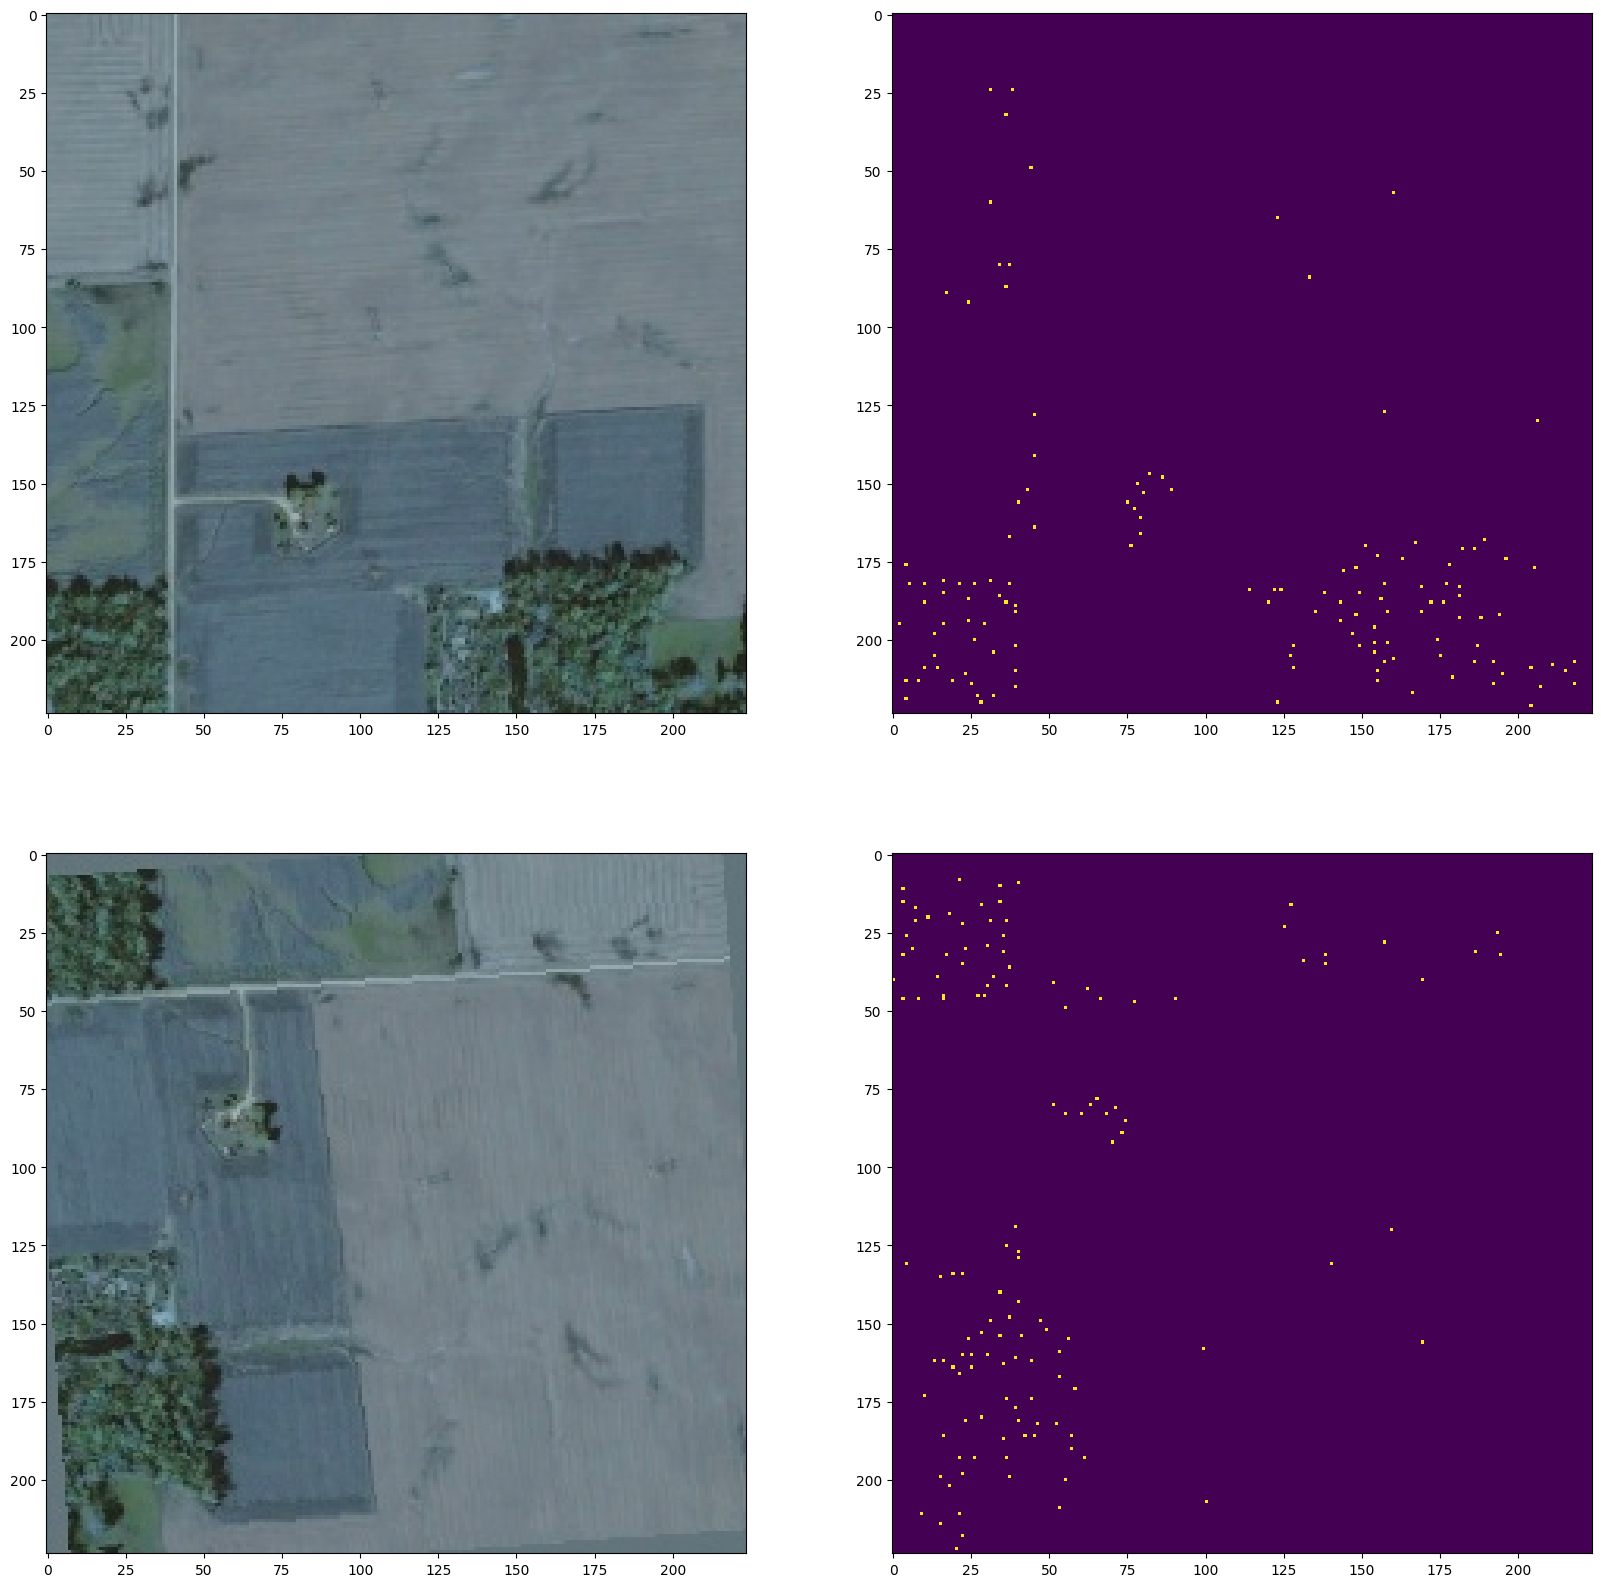

In [6]:
image = cv2.imread('processed/loc5/0/0.jpg')
mask = np.load('processed/loc5/0/0.npy')
aug_image = cv2.imread('processed/loc5/0/0_aug_0.jpg')
aug_mask = np.load('processed/loc5/0/0_aug_0.npy')

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axes[0][0].imshow(image)
axes[0][1].imshow(mask)
axes[1][0].imshow(aug_image)
axes[1][1].imshow(aug_mask)

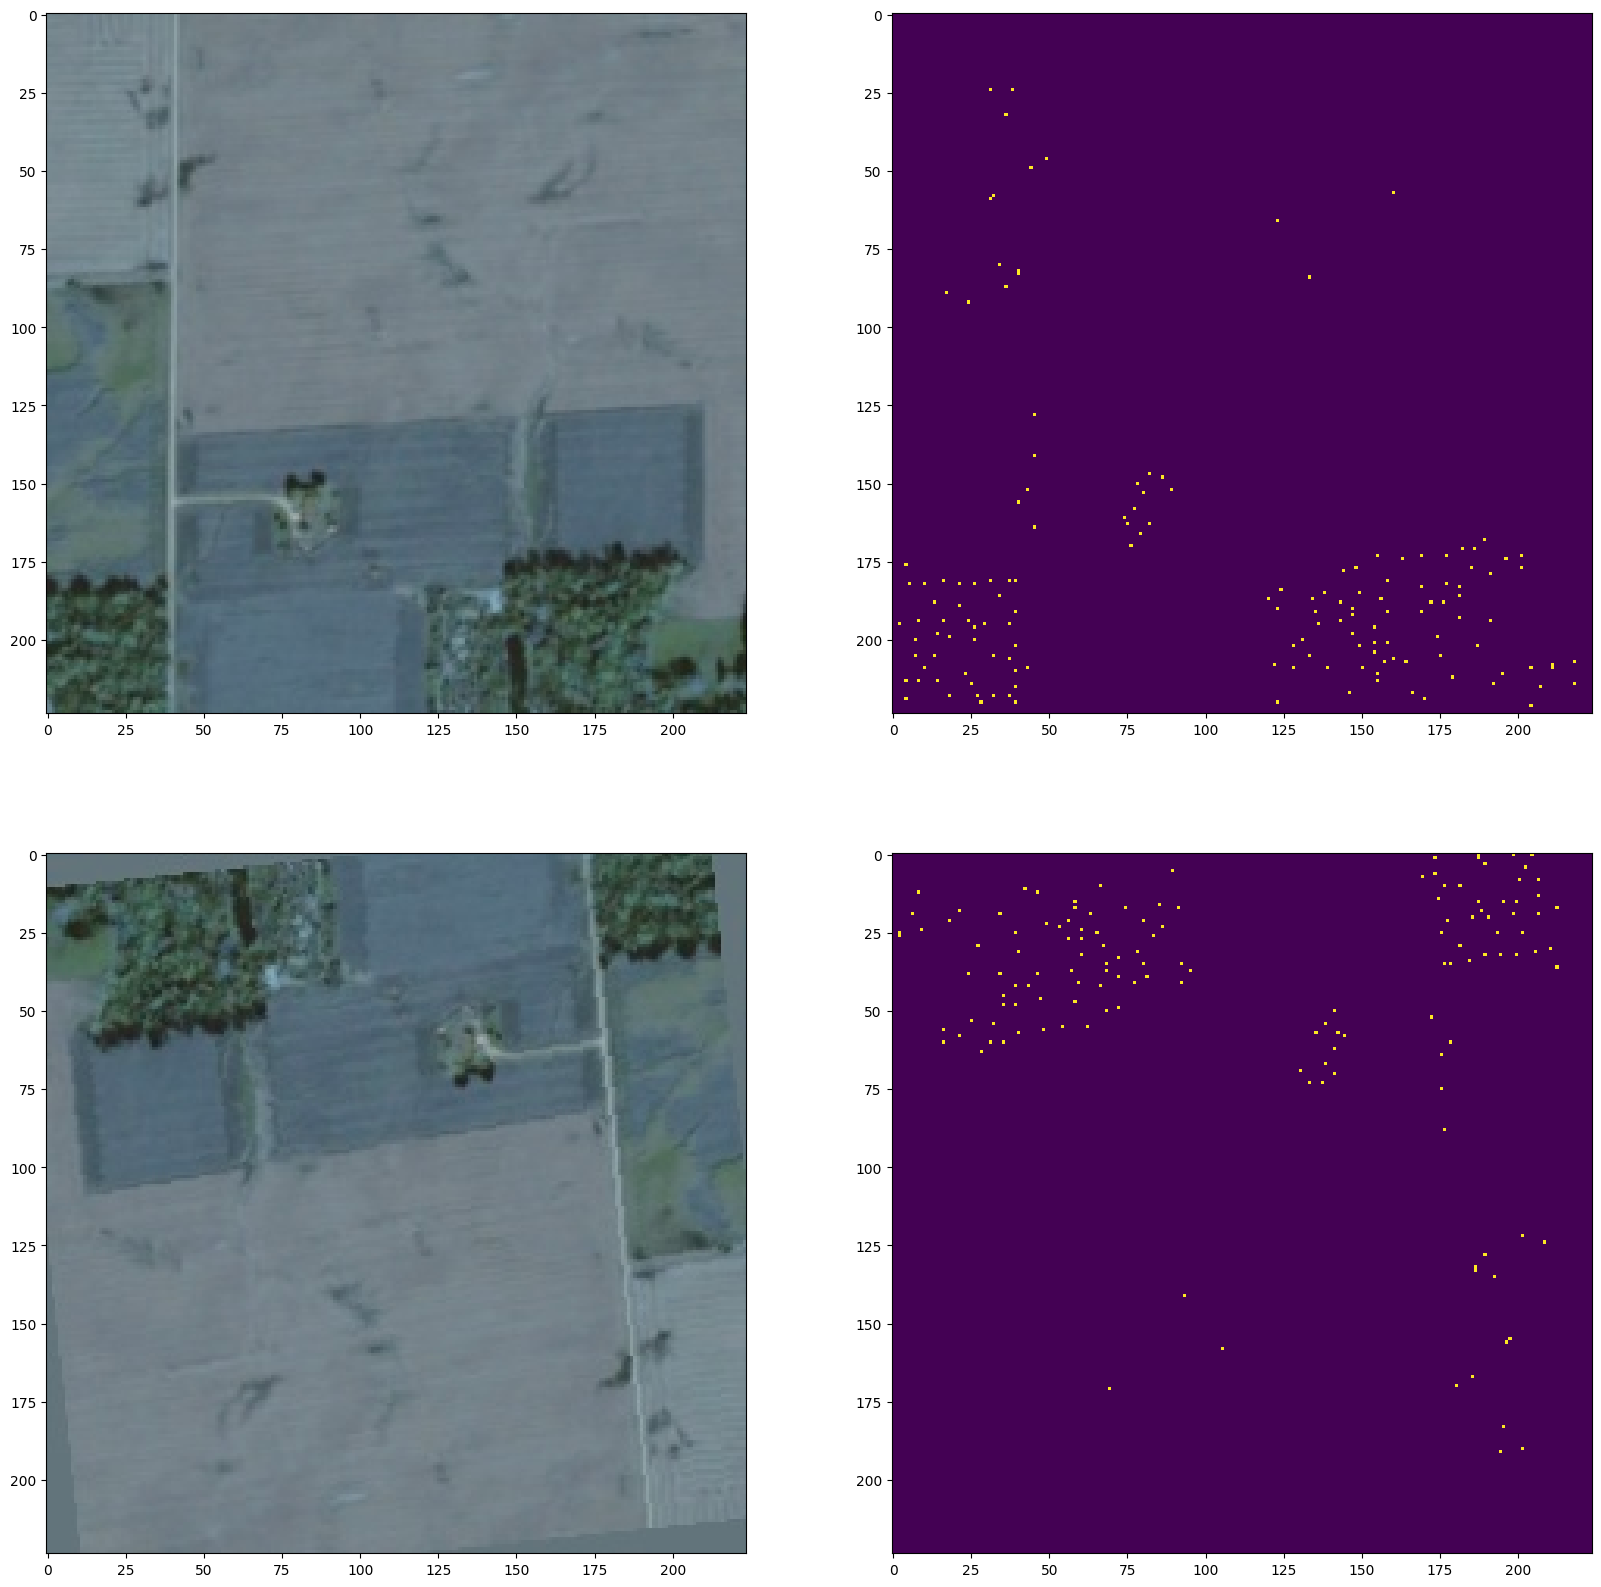

In [7]:
image = cv2.imread('processed_test/loc5/0/0.jpg')
mask = np.load('processed_test/loc5/0/0.npy')
aug_image = cv2.imread('processed_test/loc5/0/0_aug_0.jpg')
aug_mask = np.load('processed_test/loc5/0/0_aug_0.npy')

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axes[0][0].imshow(image)
axes[0][1].imshow(mask)
axes[1][0].imshow(aug_image)
axes[1][1].imshow(aug_mask)

In [75]:
def draw_keypoints(image):
    sift = cv2.SIFT_create()
    keypoints = sift.detect(image)

    detected_image = image.copy()
    for keypoint in keypoints:
        x, y = keypoint.pt

        detected_image = cv2.circle(detected_image, center=(int(x), int(y)), radius=1, color=(0, 0, 255))
    mask = get_mask(image, sift)

    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))

    axes[0].imshow(image)
    axes[1].imshow(detected_image)
    axes[2].imshow(mask)

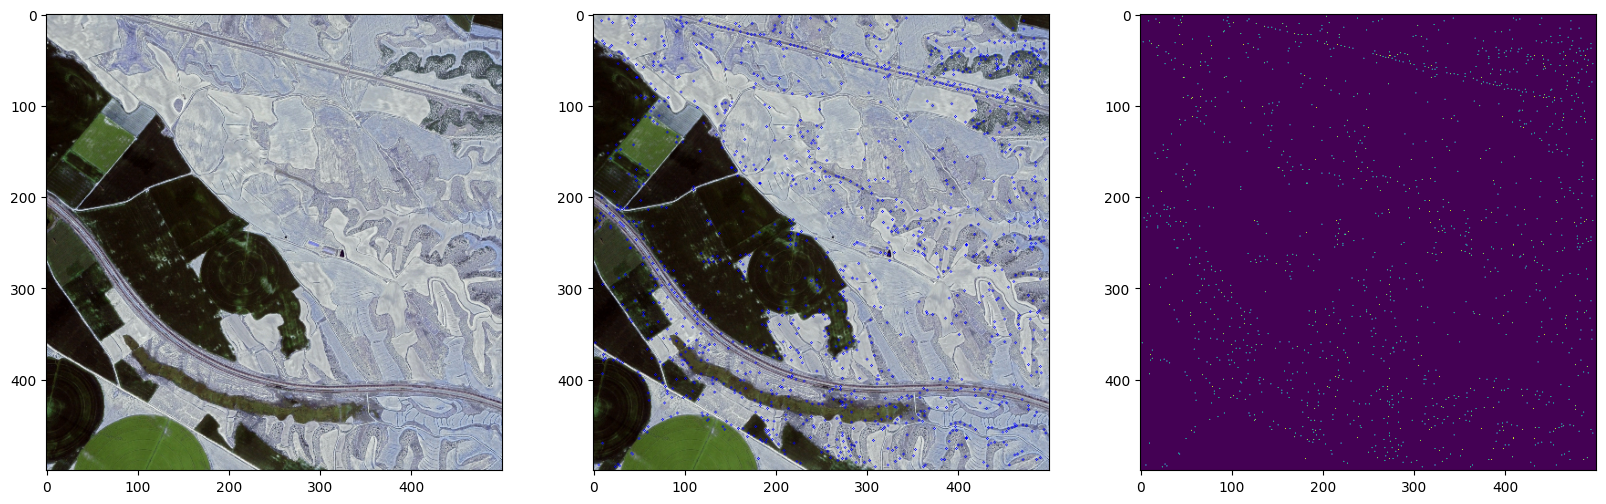

In [77]:
draw_keypoints(cv2.resize(result[0], dsize=(500, 500)))